<a href="https://colab.research.google.com/github/Chaddol/AI_ML/blob/main/Chest%20X-ray/Data_imbalance_Weighted_B_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from tqdm import tqdm
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content

!unzip -qq '/content/drive/MyDrive/팀 프로젝트/흉부_xray/Training.zip'

/content


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=90,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2
                                   )

test_datagen = ImageDataGenerator(validation_split=0.2)

In [ ]:
input_shape = 224
batch_size = 32

In [ ]:
data_dir = '/content/raw/Ch03'

# f = data_dir + '/.ipynb_checkpoints'
!rmdir /content/raw/Ch03/.ipynb_checkpoints

rmdir: failed to remove '/content/raw/Ch03/.ipynb_checkpoints': No such file or directory


In [ ]:
import os
os.rename(data_dir + '/ABN', data_dir + '/1')
os.rename(data_dir + '/NOR', data_dir + '/0')

In [ ]:

train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size = (input_shape,input_shape),
                                                    batch_size=batch_size,
                                                    class_mode='sparse',
                                                    seed=42,
                                                    subset='training')

test_generator = test_datagen.flow_from_directory(data_dir,
                                                  target_size=(input_shape,input_shape),
                                                  batch_size=batch_size,
                                                  class_mode='sparse',
                                                  seed=42,
                                                  subset='validation')

Found 7967 images belonging to 2 classes.
Found 1991 images belonging to 2 classes.


In [ ]:
labels = (train_generator.class_indices)
n_classes = len(labels)
labels

{'0': 0, '1': 1}

In [ ]:
import os
num_0 = len(os.listdir(data_dir + '/0'))
num_1 = len(os.listdir(data_dir + '/1'))
rate_0 = num_0/(num_0 + num_1)
rate_1 = num_1/(num_0 + num_1)
rate_0, rate_1

(0.9763004619401486, 0.023699538059851376)

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

def chexnet(input_shape=(224,224,3)):
    base_model = tf.keras.applications.densenet.DenseNet121(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=input_shape)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

model = chexnet()
model.summary()

In [ ]:
# import tensorflow as tf

class RecallAccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, name='recall_accuracy', **kwargs):
        super(RecallAccuracyMetric, self).__init__(name=name, **kwargs)
        self.recall = tf.keras.metrics.Recall()
        self.accuracy = tf.keras.metrics.BinaryAccuracy()
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.recall.update_state(y_true, y_pred, sample_weight)
        self.accuracy.update_state(y_true, y_pred, sample_weight)
        
    def result(self):
        recall = self.recall.result()
        accuracy = self.accuracy.result()
        return (0.5 * recall) + (0.5 * accuracy)
    
    def reset_states(self):
        self.recall.reset_states()
        self.accuracy.reset_states()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               
               loss='binary_crossentropy',
               metrics=['binary_accuracy',tf.keras.metrics.Recall(),RecallAccuracyMetric()])

saved_model = '/content/drive/MyDrive/팀 프로젝트/흉부_xray/224/all/' + 'Ch03' + '_CheXNet_test1.h5'

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_recall_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator,
          epochs=1000,
          validation_data=test_generator,
        #   steps_per_epoch=len(train_generator),
        #   validation_steps=len(test_generator),
          callbacks=[es, mc],
          class_weight={0:rate_1/rate_0, 1:1.}
          )


Epoch 1/1000
249/249 [==============================] - ETA: 0s - loss: 0.0323 - binary_accuracy: 0.6459 - recall: 0.5926 - recall_accuracy: 0.6193

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:2416: UserWarning: Metric RecallAccuracyMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_recall_accuracy improved from -inf to 0.51283, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/224/all/Ch03_CheXNet_test1.h5
249/249 [==============================] - 230s 607ms/step - loss: 0.0323 - binary_accuracy: 0.6459 - recall: 0.5926 - recall_accuracy: 0.6193 - val_loss: 0.1274 - val_binary_accuracy: 0.9618 - val_recall: 0.0638 - val_recall_accuracy: 0.5128
Epoch 2/1000
249/249 [==============================] - ETA: 0s - loss: 0.0256 - binary_accuracy: 0.7192 - recall: 0.7725 - recall_accuracy: 0.7459
Epoch 2: val_recall_accuracy improved from 0.51283 to 0.70516, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/224/all/Ch03_CheXNet_test1.h5
249/249 [==============================] - 149s 597ms/step - loss: 0.0256 - binary_accuracy: 0.7192 - recall: 0.7725 - recall_accuracy: 0.7459 - val_loss: 0.1619 - val_binary_accuracy: 0.9422 - val_recall: 0.4681 - val_recall_accuracy: 0.7052
Epoch 3/1000
249/249 [==============================] 

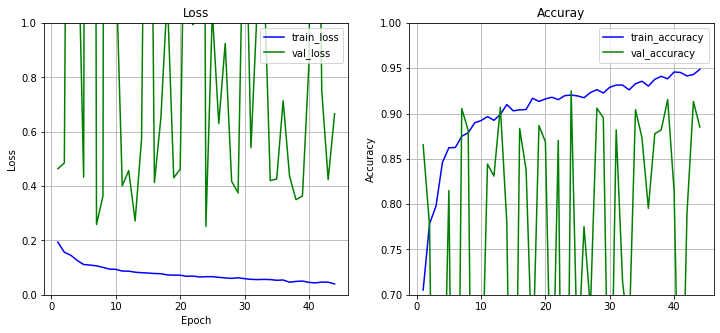

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(epochs, history.history['loss'], 'b', label='train_loss')
plt.plot(epochs, history.history['val_loss'], 'g', label='val_loss')
plt.ylim([0,1.0])
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuray')
plt.plot(epochs, history.history['binary_accuracy'], 'b', label='train_accuracy')
plt.plot(epochs, history.history['val_binary_accuracy'], 'g', label='val_accuracy')
plt.ylim([0.7,1])
plt.grid(True)
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
x_valid = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/224/valid/Ch03_x_Valid.npy')
y_valid = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/224/valid/Ch03_y_Valid.npy')

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import custom_object_scope


with custom_object_scope({'RecallAccuracyMetric': RecallAccuracyMetric}):
    model = tf.keras.models.load_model(saved_model)

    

In [ ]:
y_out = model.predict(x_valid)
y_predict = np.round(y_out)

66/66 [==============================] - 361s 5s/step


In [ ]:
y_1 = []
y_0 = []
x_0 = []
x_1 = []
for idx, i in enumerate(y_valid):
  if i == 1:
    y_1.append(i)
    x_1.append(x_valid[idx])
  else:
    y_0.append(i)
    x_0.append(x_valid[idx])

x_0 = np.array(x_0)
y_0 = np.array(y_0)
x_1 = np.array(x_1)
y_1 = np.array(y_1)

<function matplotlib.pyplot.show(*args, **kw)>

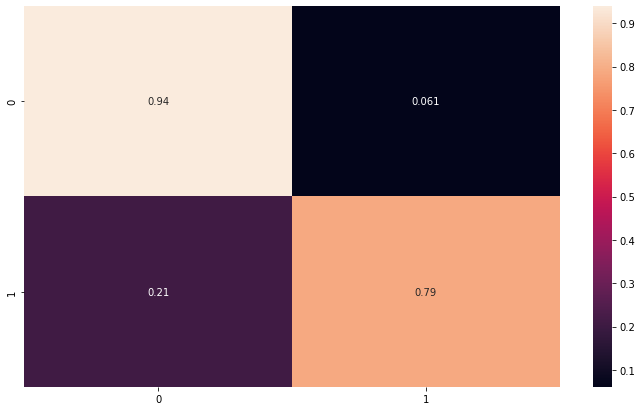

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# x_0은 label == 0인 데이터, x_1은 label == 1인 데이터만 모은 것
cf_matrix = confusion_matrix(y_valid, y_predict) / np.array([x_0.shape[0], x_1.shape[0]]).reshape(-1,1)

plt.figure(figsize = (12,7))
sns.heatmap(cf_matrix, annot=True)
plt.show

In [ ]:
y_out

array([[1.8984620e-05],
       [6.1610381e-06],
       [1.8984620e-05],
       ...,
       [7.0107717e-04],
       [1.7870307e-02],
       [4.2321363e-01]], dtype=float32)

In [ ]:
np.mean(model.predict(x_1))

2/2 [==============================] - 7s 1s/step


0.7755943

In [ ]:
np.mean(model.predict(x_0))

65/65 [==============================] - 345s 5s/step


0.07822225